# CrossFit Retention Project — 01 Exploratory Analysis
Initial EDA on raw PushPress exports: Members, Attendance, Store Sales, and Cancellations.

**Goal**: Understand data quality, build basic retention metrics, and surface quick insights for the owner.

In [11]:
import os

import matplotlib.pyplot as plt
import pandas as pd

CURRENT_DIR = os.path.abspath("..")
RAW_DATA_DIR = os.path.join(CURRENT_DIR, "data", "raw")
MEMBERS_CSV = os.path.join(RAW_DATA_DIR, "Members.csv")
ATTENDANCE_CSV = os.path.join(RAW_DATA_DIR, "Attendance.csv")
SALES_CSV = os.path.join(RAW_DATA_DIR, "Store_Sales.csv")
CANCELLATIONS_CSV = os.path.join(RAW_DATA_DIR, "Cancellations.csv")

members = pd.read_csv(MEMBERS_CSV, parse_dates=["Join_Date"])
attendance = pd.read_csv(ATTENDANCE_CSV, parse_dates=["Date"])
sales = pd.read_csv(SALES_CSV, parse_dates=["Purchase_Date"])
cancellations = pd.read_csv(CANCELLATIONS_CSV, parse_dates=["Cancel_Date"])

members.head(3), attendance.head(3), sales.head(3), cancellations.head(3)

(   Member_ID First_Name  Join_Date Membership_Type Referral_Source
 0          1    Member1 2024-11-23      Punch Card          Friend
 1          2    Member2 2024-02-27     Foundations          Friend
 2          3    Member3 2024-01-13       Unlimited          Google,
    Member_ID       Date     Class_Type    Coach      Status
 0          1 2025-06-06       Open Gym  Coach D  Checked In
 1          1 2025-02-23       CrossFit  Coach C  Checked In
 2          1 2025-08-30  Weightlifting  Coach C  Checked In,
    Member_ID Purchase_Date                Item  Amount_USD
 0          1    2025-09-09      Protein Powder       28.91
 1          1    2025-08-14       Shaker Bottle       84.26
 2          1    2025-02-01  Membership Upgrade      113.31,
    Member_ID Cancel_Date
 0        204  2025-05-11
 1        267  2025-04-16
 2        153  2024-07-23)

## Basic Shapes & Nulls

In [12]:
for name, df in {
    "members": members,
    "attendance": attendance,
    "sales": sales,
    "cancellations": cancellations,
}.items():
    print(name, df.shape)
    display(df.isna().mean().sort_values(ascending=False).to_frame("null_rate"))

members (300, 5)


,null_rate
Member_ID,0.0
First_Name,0.0
Join_Date,0.0
Membership_Type,0.0
Referral_Source,0.0


attendance (24166, 5)


,null_rate
Member_ID,0.0
Date,0.0
Class_Type,0.0
Coach,0.0
Status,0.0


sales (1477, 4)


,null_rate
Member_ID,0.0
Purchase_Date,0.0
Item,0.0
Amount_USD,0.0


cancellations (44, 2)


,null_rate
Member_ID,0.0
Cancel_Date,0.0


## Member Growth Over Time

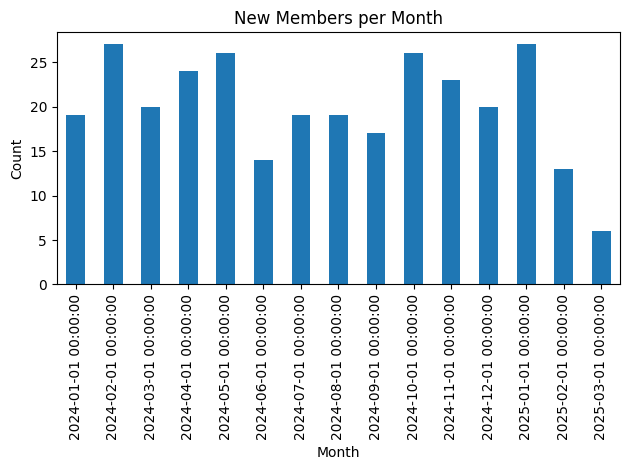

In [13]:
members_by_month = (
    members.assign(month=members["Join_Date"].dt.to_period("M").dt.to_timestamp())
    .groupby("month")
    .size()
)
plt.figure()
members_by_month.plot(kind="bar")
plt.title("New Members per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Cancellations Over Time

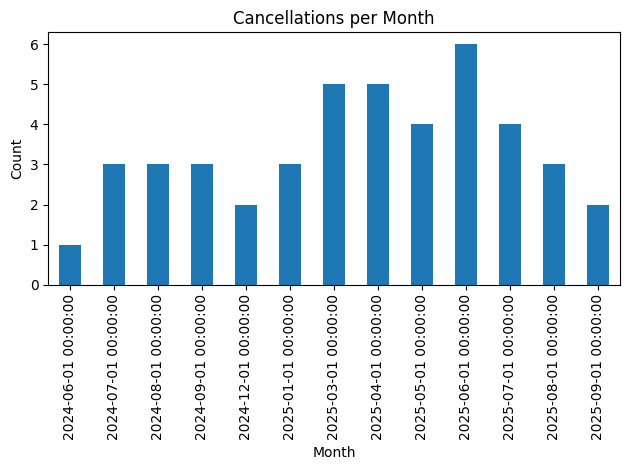

In [14]:
cancels_by_month = (
    cancellations.assign(month=cancellations["Cancel_Date"].dt.to_period("M").dt.to_timestamp())
    .groupby("month")
    .size()
)
plt.figure()
cancels_by_month.plot(kind="bar")
plt.title("Cancellations per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Current Churn Snapshot

In [15]:
active_ids = set(members["Member_ID"]) - set(cancellations["Member_ID"])
churn_rate = len(set(cancellations["Member_ID"])) / len(set(members["Member_ID"]))
print(
    f"Members: {members['Member_ID'].nunique()} | Cancelled: {cancellations['Member_ID'].nunique()} | Churn Rate: {churn_rate:.2%}"
)
print(f"Active Members (approx): {len(active_ids)}")

Members: 300 | Cancelled: 44 | Churn Rate: 14.67%
Active Members (approx): 256


## Attendance Patterns

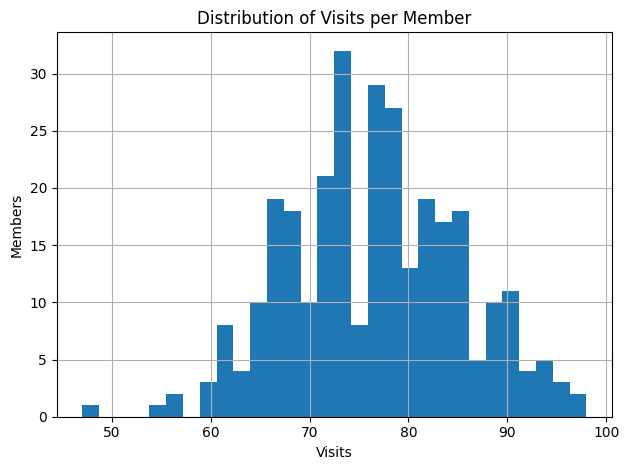

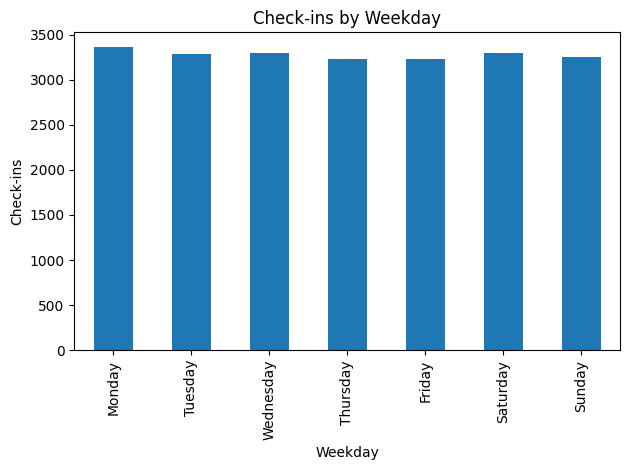

In [16]:
# Visits per member
visits_per_member = attendance[attendance["Status"].eq("Checked In")].groupby("Member_ID").size()
plt.figure()
visits_per_member.hist(bins=30)
plt.title("Distribution of Visits per Member")
plt.xlabel("Visits")
plt.ylabel("Members")
plt.tight_layout()
plt.show()

# Peak days/times
att = attendance.copy()
att["weekday"] = att["Date"].dt.day_name()
by_weekday = (
    att[att["Status"].eq("Checked In")]
    .groupby("weekday")
    .size()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)
plt.figure()
by_weekday.plot(kind="bar")
plt.title("Check-ins by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Check-ins")
plt.tight_layout()
plt.show()

## Membership Type Mix & Referral Sources

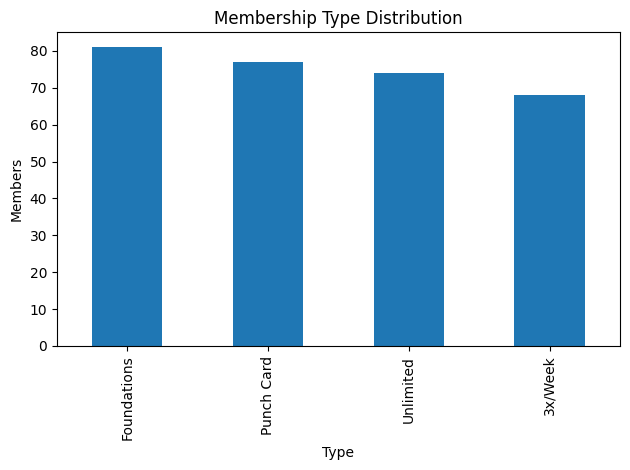

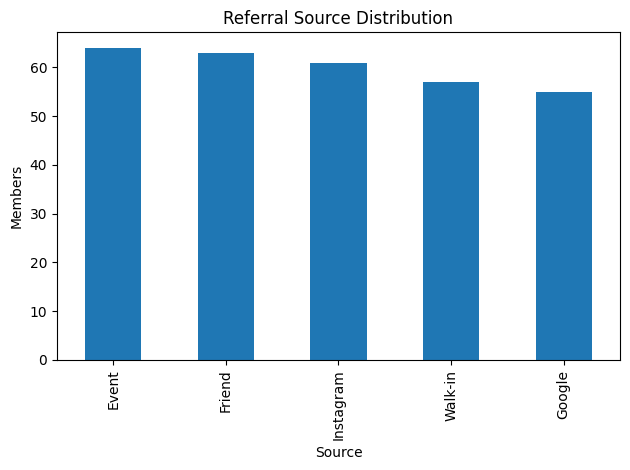

In [17]:
plt.figure()
members["Membership_Type"].value_counts().plot(kind="bar")
plt.title("Membership Type Distribution")
plt.xlabel("Type")
plt.ylabel("Members")
plt.tight_layout()
plt.show()

plt.figure()
members["Referral_Source"].value_counts().plot(kind="bar")
plt.title("Referral Source Distribution")
plt.xlabel("Source")
plt.ylabel("Members")
plt.tight_layout()
plt.show()

## Retail Sales Overview

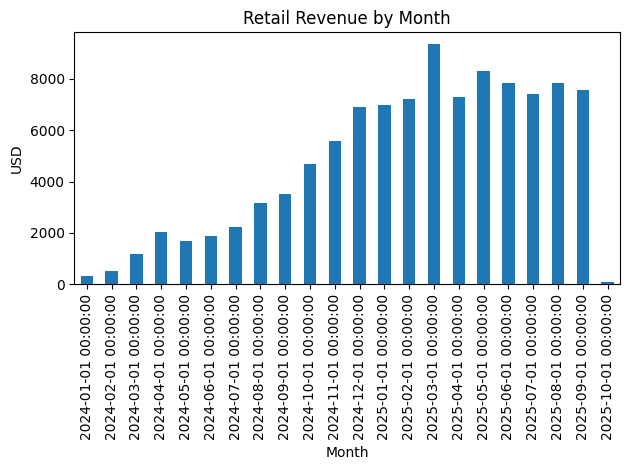

,Revenue_USD
Item,
T-Shirt,22661.41
Pre-Workout,21057.17
Protein Powder,20335.34
Membership Upgrade,19851.72
Shaker Bottle,19544.42


In [18]:
sales["month"] = sales["Purchase_Date"].dt.to_period("M").dt.to_timestamp()
sales_monthly = sales.groupby("month")["Amount_USD"].sum()
plt.figure()
sales_monthly.plot(kind="bar")
plt.title("Retail Revenue by Month")
plt.xlabel("Month")
plt.ylabel("USD")
plt.tight_layout()
plt.show()

top_items = sales.groupby("Item")["Amount_USD"].sum().sort_values(ascending=False)
display(top_items.to_frame("Revenue_USD"))

## Quick Retention Signals (Heuristics)

In [19]:
# Days since last check-in
last_seen = (
    attendance[attendance["Status"].eq("Checked In")]
    .groupby("Member_ID")["Date"]
    .max()
    .rename("Last_Checkin")
)
features = members.set_index("Member_ID").join(last_seen).reset_index()
snapshot_date = max(attendance["Date"])
features["Days_Since_Last"] = (snapshot_date - features["Last_Checkin"]).dt.days

# Visit frequency (visits per active month)
first_seen = (
    attendance[attendance["Status"].eq("Checked In")]
    .groupby("Member_ID")["Date"]
    .min()
    .rename("First_Checkin")
)
totals = (
    attendance[attendance["Status"].eq("Checked In")]
    .groupby("Member_ID")
    .size()
    .rename("Total_Checkins")
)
features = features.set_index("Member_ID").join(first_seen).join(totals).reset_index()
features["Months_Active"] = (
    (
        features["Last_Checkin"].dt.to_period("M") - features["First_Checkin"].dt.to_period("M")
    ).apply(lambda p: p.n)
    + 1
).clip(lower=1)
features["Visits_per_Month"] = (features["Total_Checkins"] / features["Months_Active"]).fillna(0)

# Retail spend
spend = sales.groupby("Member_ID")["Amount_USD"].sum().rename("Retail_Spend_USD")
features = features.set_index("Member_ID").join(spend).reset_index().fillna({"Retail_Spend_USD": 0})

# Label churned
features["Churned"] = features["Member_ID"].isin(set(cancellations["Member_ID"])).astype(int)

display(features.head(10))
print(
    "Heuristic: Members with high 'Days_Since_Last' and low 'Visits_per_Month' are at higher risk."
)

,Member_ID,First_Name,Join_Date,Membership_Type,Referral_Source,Last_Checkin,Days_Since_Last,First_Checkin,Total_Checkins,Months_Active,Visits_per_Month,Retail_Spend_USD,Churned
0,1,Member1,2024-11-23,Punch Card,Friend,2025-10-01,0,2024-11-24,85,12,7.083333,311.75,0
1,2,Member2,2024-02-27,Foundations,Friend,2025-09-29,2,2024-03-18,94,19,4.947368,343.90,0
2,3,Member3,2024-01-13,Unlimited,Google,2025-09-29,2,2024-01-18,80,21,3.809524,625.86,0
3,4,Member4,2025-01-14,Punch Card,Instagram,2025-10-01,0,2025-01-14,68,10,6.800000,539.33,0
4,5,Member5,2024-05-20,Punch Card,Walk-in,2025-10-01,0,2024-05-25,77,18,4.277778,569.10,0
5,6,Member6,2024-05-05,Foundations,Event,2025-09-19,12,2024-05-25,86,17,5.058824,163.91,1
6,7,Member7,2024-04-24,Unlimited,Instagram,2025-09-28,3,2024-05-03,78,17,4.588235,635.66,0
7,8,Member8,2024-03-12,Unlimited,Event,2025-09-24,7,2024-03-13,79,19,4.157895,393.72,1
8,9,Member9,2025-01-12,Punch Card,Google,2025-09-29,2,2025-01-14,92,9,10.222222,171.29,0
9,10,Member10,2024-02-22,3x/Week,Google,2025-09-29,2,2024-02-27,72,20,3.600000,469.04,1


Heuristic: Members with high 'Days_Since_Last' and low 'Visits_per_Month' are at higher risk.
